In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack, hstack, join
import re
import warnings
from tqdm import tqdm

from astroquery.simbad import Simbad
from astroquery.nist import Nist
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier

## Peruse GALEX catalogues, find most promising one

In [ ]:
# ## Find catalogues with GALEX FUV magnitudes

# galex_cat = Vizier.find_catalogs('GALEX')
# # search = ['FGK', 'Late']

# for k, v in galex_cat.items(): 
#     print(k, v.description)


In [ ]:
# table_list = Vizier.get_catalogs(galex_cat.keys())
# print( table_list )

In [ ]:
# keys = table_list.keys()[2:7]
# print( keys )

# for k in keys: print(table_list[k].columns)

## Peruse IUE catalogues, identify most promising one

In [ ]:
# iue_cat = Vizier.find_catalogs('IUE')
# for k, v in iue_cat.items(): print(k, v.description)

In [ ]:
# table_list = Vizier.get_catalogs(iue_cat.keys())
# print( table_list )

## Catalogue choices

### GALEX catalogues of interest:

II/335 Revised catalog of GALEX UV sources (GUVcat_AIS GR6+7) (Bianchi+ 2017) 

J/ApJ/766/9 GALEX observations of exoplanet host stars (Shkolnik, 2013) 

J/AJ/160/217 342 FGK-dwarfs ages using GALEX FUV magnitudes (Crandall+, 2020) 


### IUE catalogues of interest:

VI/110 Final Merged Log of IUE Observations (NASA-ESA, 2000)

In [2]:
GALEXCAT = 'II/335/galex_ais'
IUECAT = 'VI/110/inescat'

In [234]:
# iue_catlg_list = Vizier.find_catalogs('IUE')
iue_table_list = Vizier.get_catalogs(Vizier.find_catalogs('IUE').keys())
iue_data = iue_table_list['VI/110/inescat']
iue_data.columns

<TableColumns names=('Obs','ExpTime','Object','RAJ2000','DEJ2000','IUEClass','Spectrum')>

## Create combined dataset between GALEX, IUE, and SIMBAD

In [254]:
## Lol XMatch query isn't working
# match = XMatch.query(request='xmatch', cat1='II/335/galex_ais', cat2='VI/110/inescat', max_distance=1. * u.arcsec)
match = pd.read_csv('/Users/isabelkain/Desktop/GALEX/xmatch_galexais_inescat.csv')
print('Raw dataset length:', len(match))

## Drop columns from IUE catalogue (for cleanliness)
match.drop(columns=['Obs','ExpTime','RAJ2000','DEJ2000','IUEClass','Spectrum', 'Obs.1', 'RAJ2000.1', 'DEJ2000.1'], inplace=True)

## Clean rows with empty FUV magnitudes
print('Number of rows without FUV mags:', np.sum(np.isnan(match['FUVmag'])) )
match.dropna(axis=0, subset=['FUVmag'], inplace=True)

## Reformat IUE object names
match['Object'] = match['Object'].str.strip()

## Scrub duplicate rows
print('Duplicate rows:', np.sum(match.duplicated()) )
match = match[ ~match.duplicated() ]

# print(match.columns)
match


Raw dataset length: 15458
Number of rows without FUV mags: 3121
Duplicate rows: 10817


,angDist,name,objid,phID,Cat,RAfdeg,DEfdeg,FUVexp,NUVexp,GLON,...,Gd,Nd,primidd,groupidd,grouptot,OName,Size,_RAJ2000,_DEJ2000,Object
0,1.506431,GALEX J040917.1+304633,6377636018877629269,6377636018874482688,AIS,62.344986,30.850570,108.10,115.10,165.5342,...,0,1,6377636018877629440,6377636018877629269,6377636018877629269,N,0.00,62.3208,30.7760,HD 281679
1,1.788113,GALEX J204409.7-104324,6379641508759339455,6379641508756193280,AIS,311.302134,-10.322512,160.00,160.00,35.9712,...,0,1,6379641508759339008,6379641508759339455,6379641508759339455,N,0.00,311.0410,-10.7234,Mrk 509
2,0.511658,GALEX J040748.4-121136,6377495302864111507,6377495302860963840,AIS,61.798920,-12.249459,109.00,109.00,204.9273,...,0,1,6377495302864111616,6377495302864111507,6377495302864111507,N,0.00,61.9520,-12.1935,QSO 0405-1219
3,0.452777,GALEX J074232.8+494834,6373695375646131989,6373695375642984448,AIS,114.958984,49.816084,217.00,217.00,168.6027,...,0,1,6373695375646132224,6373695375646131989,6373695375646131989,GA:UGC03973,80.38,115.6369,49.8096,Mrk 79
4,0.989020,GALEX J122906.7+020307,6378937856751043795,6378937856747896832,AIS,187.148572,2.144949,109.00,109.00,289.9516,...,0,1,6378937856751043584,6378937856751043795,6378937856751043795,N,0.00,187.2779,2.0524,PG 1226+023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15285,0.581387,GALEX J001438.3-185558,6380591472847094403,6380591472843948032,AIS,3.602268,-18.637168,112.00,112.00,75.1071,...,0,1,6380591472847094784,6380591472847094403,6380591472847094403,N,0.00,3.6601,-18.9329,HD 1038
15308,4.071352,GALEX J115805.4+275240,6374856462072547130,6374856462069399552,AIS,179.494590,27.815766,109.00,109.00,206.2320,...,0,1,6374856462072547328,6374856462072547130,6374856462072547130,GA:NGC4004,70.49,179.5213,27.8780,NGC 4004
15352,1.248194,GALEX J221852.0-033536,6376439741636676371,6376439741633527808,AIS,335.104001,-3.775451,204.05,204.05,59.0439,...,0,1,6376439741636676608,6376439741636676371,6376439741636676371,N,0.00,334.7172,-3.5935,QSO 2216-0350
15454,1.469770,GALEX J131011.6+460124,6374715670897101027,6374715670893953024,AIS,197.264105,46.156803,208.00,214.00,113.0217,...,0,1,6374715670897100800,6374715670897101027,6374715670897101027,N,0.00,197.5478,46.0233,IUE SKY


In [239]:
# # # Filter to FGK stars using IUE object class: 
# # # cdsarc.cds.unistra.fr/viz-bin/vizExec/w/getclass?-plus=-+&VI/110&21

# #   38   Horizontal Branch 
# #   39   Composite
# #   40   F0-F2                   
# #   41   F3-F9
# #   42   Fp
# #   43   Late Type Degenerate Stars
# #   44   G IV-VI
# #   45   G I-III
# #   46   K IV-VI
# #   47   K I-III
# #   64   Other stellar Object
# #   65   Misidentified targets
 
# # crit = (match['IUEClass'] >= 38) & (match['IUEClass'] <= 47) & (match['IUEClass'] == 64) & (match['IUEClass'] == 65)
# c1 = np.logical_and( (match['IUEClass'] >= 38), (match['IUEClass'] <= 47) )
# c2 = np.logical_or( (match['IUEClass'] == 64), (match['IUEClass'] == 65) )
# crit = np.logical_or(c1, c2)

# match = match[crit].reset_index(drop=True)
# match

In [6]:
## To view all votable fields (fields you can query Simbad with):
# Simbad.list_votable_fields()

## For a description of a specific field:
# Simbad.get_field_description('ubv')

In [240]:
# def skipped_scripts_nums(results):
#     '''Returns 1-based script numbers that resulted in failed queries'''
    
#     ## Identify which script numbers resulted in failed queries
#     ## (the failed script number will not be in the returned results VOtable)
    
#     idcol = np.array(results['SCRIPT_NUMBER_ID'])
#     idskips = np.array([]) # 1-based numbering of script IDs that were not successful

#     for i in range(len(idcol)-1):

#         if idcol[i+1] - idcol[i] > 1:
#             idskips = np.concatenate(( idskips, np.arange( idcol[i]+1, idcol[i] + (idcol[i+1] - idcol[i])) )) # 1-based script number of skipped query.

#     idskips = idskips.astype(int, copy=False)
#     return( idskips )


In [241]:
# idcol = np.array(results['SCRIPT_NUMBER_ID'])
# idskips = np.array([]) # 1-based numbering of script IDs that were not successful

# for i in range(len(idcol)-1):

#     if idcol[i+1] - idcol[i] > 1:
#         print(idcol[i], idcol[i+1], 'Difference:', idcol[i+1] - idcol[i])
#         print(idcol[i-3:i+3])
#         idskips = np.concatenate(( idskips, np.arange( idcol[i]+1, idcol[i] + (idcol[i+1] - idcol[i])) )) # 1-based script number of skipped query.

# idskips = idskips.astype(int, copy=False)
# print(idskips)


# # np.arange( idcol[i], idcol[i] + (idcol[i+1] - idcol[i]))

In [242]:
# ## For each object in match dataframe, query Simbad for other data (e.g. spectral type)

# fields = ['fe_h', 'flux(B)','flux(V)','flux(R)','flux(I)','flux(J)',
#           'flux(K)', 'flux_error(B)','flux_error(V)','flux_error(R)',
#           'flux_error(I)','flux_error(J)','flux_error(K)', 'rot', 
#           'sptype', 'otype', 'td1', 'ubv', 'parallax', 'distance']

# customSimbad = Simbad()
# for f in fields: customSimbad.add_votable_fields(f)
    
# print('Original match length:', len(match))


# ## Query Simbad in batches to avoid timeout

# l = np.min([800, len(match)]) # query in batches of 800 or the length of the table, whichever is smaller

# ## Do first batched Simbad query
# results = customSimbad.query_objects(match.loc[:l,'Object'])

# failedscriptIDs = skipped_scripts_nums(results) # 1-based numbering of scripts (queries) that failed
# print('Failed script IDs:', failedscriptIDs)

# ## Drop failed queries from match dataframe
# drop = [True]*len(match)

# for s in failedscriptIDs-1: # drop 0-based index of failed queries
#     drop[s] = False

# ## If match dataframe is larger than one batch of length l, then batch match dataframe into queries of size l
# if len(match) > l:
    
#     i = l
    
#     while i <= len(match):
        
#         ## Track progress
#         print('while: indexing', i, 'through', i+l)
        
#         ## Query Simbad
#         r = customSimbad.query_objects(match.loc[i:i+l,'Object'])
#         failedscriptIDs = skipped_scripts_nums(r)
#         print('Failed script IDs:', failedscriptIDs)
        
#         ## Drop failed queries from match dataframe
        
#         for s in failedscriptIDs-1: 
# #             print('Index within batch:', s, 'Adjusted index:', s+i)
#             drop[s+i] = False # update index to account for batches
        
#         ## Add current batch to running query results
#         results = vstack([results, r])
        
#         ## Increment indices
#         i = i + l
        
# print('Dropping failed scripts:', len(match), len(match[drop]), np.where(~np.array(drop)))
# # match = match[drop]
        

In [ ]:
# # ## Identify objects where Simbad query failed, drop those objects from matched GALEX + IUE table

# # idcol = np.array(results['SCRIPT_NUMBER_ID'])
# # idskips = np.array([]) # 1-based numbering of script IDs that were not successful
# # # locskips = np.array([]) # 0-based index of rows in match where query was not successful
# # print(len(idcol), len(results))

# # for i in range(len(idcol)-1):
    
# #     if idcol[i+1] - idcol[i] > 1:
# #         print('0-index:', i, 'Contiguous script numbers:', idcol[i], idcol[i+1], 'Dropped object:', match.loc[idcol[i], 'Object'])        
# #         idskips = np.append(idskips, idcol[i]+1) # 1-based script number of skipped query. doesn't work for where multiple rows are skipped, but whatever
        
# # idskips = idskips.astype(int, copy=False)
# # print(idskips)

# ## Grab GALEX data table and drop objects where Simbad query failed

# glx = Table.from_pandas(match[['Object', 'name', 'FUVexp', 'FUVmag', 'e_FUVmag']])
# print('NROWS BEFORE REMOVING DROPPED QUERIES:', len(glx))
# # print('Check**:', len(glx[glx['Object']=='V* VZ CVn']))

# drop = [True]*len(glx)

# for s in idskips-1: # drop skipped query with 0-based index
#     drop[s] = False

# galex = glx[drop]
# print('NROWS AFTER REMOVING DROPPED QUERIES:', len(galex))

# print(len(results), len(galex), len(glx))

# galex


Dropped objects:

MC LHA 332- 21 -> LHA 332-21, variable G9V in Orion
BD-26 43 -> maybe BD-02 6 -- Star (no spectral classification)
HD 197076 A -> HD 197076, double star
HD 28394 (idk why this dropped), spectroscopic binary
HD 21242 (idk why this dropped), RSCVn variable
HD 117777 (idk why this dropped), eclipsing binary
HD 206860 (idk why this dropped) -> V* HN Peg -- BY Dra Variable 
HD 117880 (idk why this dropped) -> B9IV/V high PM star

In [ ]:
# ## Combine Simbad query results with Galex FUV data


# # ## Identify objects where Simbad query failed

# # idcol = np.array(results['SCRIPT_NUMBER_ID'])
# # idskips = np.array([]) # 1-based numbering of script IDs that were not successful

# # for i in range(len(idcol)-1):
    
# #     if idcol[i+1] - idcol[i] > 1:
# #         idskips = np.append(idskips, idcol[i]+1)
        
# # idskips = idskips.astype(int, copy=False)
# # print(idskips)


# ## Grab GALEX data table and drop objects where Simbad query failed

# glx = Table.from_pandas(match[['Object', 'name', 'FUVexp', 'FUVmag', 'e_FUVmag']])
# drop = [True]*len(glx)

# for s in idskips-1:
#     drop[s] = False

# galex = glx[drop]
# print('Length diff', len(glx), len(galex))


# ## Combine GALEX + Simbad returns

# if len(results) == len(galex):
#     data = hstack([results, galex])
#     display( data )
    
# else: 
#     print('Table length mismatch. Double check Simbad query.')

In [ ]:
# ## Drop variable stars from sample

# tmp_obj = list(data['MAIN_ID'])
# tmp_spt = list(data['SP_TYPE'])
# tmp_otp = list(data['OTYPE'])

# for i in range(len(tmp_obj)):
#     print(tmp_obj[i], tmp_spt[i], tmp_otp[i])

In [ ]:
# ## Explore object types in sample

# tmp_obj = list(data['MAIN_ID'])
# tmp_spt = list(data['SP_TYPE'])
# tmp_otp = list(data['OTYPE'])

# cats = np.unique(data['OTYPE'])
# counts = np.zeros(len(cats))

# for i in range(len(cats)):
#     counts[i] = np.sum( data['OTYPE'] == cats[i] )

# plt.figure(figsize=(4,12))
# plt.barh(cats, counts, edgecolor='k')
# plt.yticks(fontsize=14, c='k');
# plt.xticks(fontsize=14, c='k');
# plt.xlabel('Counts', fontsize=14, c='k');
# plt.title('SIMBAD object types in cross-matched GALEX \n(II/335/galex_ais) & IUE (VI/110/inescat) catalogues', fontsize=16, c='w')
# plt.xscale('log')

# # GALEXCAT = 'II/335/galex_ais'
# # IUECAT = 'VI/110/inescat'


In [ ]:
# droptypes = ['gammaDorV*', 'delSctV*', 'bCepV*', 'WhiteDwarf', 'Variable', 
#              'Type2Cep', 'TTauri*', 'SB*', 'RotV*', 'RVTauV*', 'RSCVnV', 
#              'OrionV*', 'LongPeriodV*_Candidate', 'InteractingG', 'Eruptive*', 
#              'EclBin', 'ClassicalCep', 'CataclyV*', 'BYDraV*', '**' ]

# dropix = [True]*len(data)


# # ## Questions about:
# # - Ae* (Herbig Ae/Be stars, actively forming but pre hydrogen burning)
# # - LongPeriodV*_Candidate
# # - LongPeriodV*
# # - Eruptive*
# # - ChemPec* (chemically peculiar stars)

In [ ]:
# plt.scatter(data['PLX_VALUE'], data['FUVexp'], alpha=0.3, ec='grey')
# plt.xlabel('FUV magnitude', color='w')
# plt.ylabel('Parallax (pc)', color='w')
# plt.xticks(c='w')
# plt.yticks(c='w')

In [256]:
# match = pd.read_csv('/Users/isabelkain/Desktop/GALEX/xmatch_galexais_inescat.csv')
# match.dropna(axis=0, subset=['FUVmag'], inplace=True)
# match['Object'] = match['Object'].str.strip()

# print( match['Object'][0] )
# match


### Query SIMBAD for object names

In [162]:
# warnings.filterwarnings('ignore')

# dframe = pd.DataFrame(data=np.full((len(match),2), ''), columns=['XMatch name', 'SIMBAD name'])
# dframe

# Simbad.add_votable_fields('typed_id')
# Simbad.add_votable_fields('sptype')

# for i, obj in enumerate(tqdm(match['Object'])):
    
#     qry = Simbad.query_object(obj)
    
#     if not qry is None:

#         dframe.loc[i,'XMatch name'] = obj
#         dframe.loc[i,'SIMBAD name'] = qry['MAIN_ID'][0]

In [257]:
warnings.filterwarnings('ignore')

## Set fields to query from Simbad
fields = ['typed_id', 'fe_h', 'flux(B)','flux(V)','flux(R)','flux(I)','flux(J)',
          'flux(K)', 'flux_error(B)','flux_error(V)','flux_error(R)',
          'flux_error(I)','flux_error(J)','flux_error(K)', 'rot', 
          'sptype', 'otype', 'td1', 'ubv', 'parallax', 'distance']

customSimbad = Simbad()

for f in fields: 
    customSimbad.add_votable_fields(f)

## Create first row of results table
matchTable = Table.from_pandas(match)
r = customSimbad.query_object(match['Object'][0])

results = hstack([matchTable[0], r])


## Iterate through all rows in match, query each object and add combined data to results
    
for i, obj in enumerate(tqdm(match['Object'])):
    
    ## Skip first row, already included
    if i==0:
        continue
    
    ## Ask Simbad for information
    simbadqry = customSimbad.query_object(obj)
    
    ## Make a new row with XMatch + Simbad info for the object
    newrow = hstack([matchTable[i], simbadqry])
    
    ## Add new row to results table
    results = vstack([results, newrow])
    

## Drop rows where SIMBAD doesn't give any spectral type
results = results[results['SP_TYPE'] != '']


100%|███████████████████████████████████████| 1520/1520 [09:45<00:00,  2.60it/s]


In [359]:
## Limit sample to FGK stars

sptypes = np.array(['F', 'G', 'K'])
fgk_index = [False]*len(results)

for i, spt in enumerate(results['SP_TYPE'].compressed()):
    
    cond = False
    
    for s in sptypes:
        cond = np.logical_or(cond, np.any(np.isin([*spt], s)))
        
    if cond:
        fgk_index[i] = True
        
results = results[fgk_index]

results

angDist,name,objid,phID,Cat,RAfdeg,DEfdeg,FUVexp,NUVexp,GLON,GLAT,tile,img,sv,r.fov,b,E(B-V),Sp?,chkf,FUVmag,e_FUVmag,NUVmag,e_NUVmag,FUV.a,e_FUV.a,NUV.a,e_NUV.a,FUV.4,e_FUV.4,NUV.4,e_NUV.4,FUV.6,e_FUV.6,NUV.6,e_NUV.6,Fafl,Nafl,Fexf,Nexf,Fflux,e_Fflux,Nflux,e_Nflux,FXpos,FYpos,NXpos,NYpos,Fima,Nima,Fr,Nr,nS/G,fS/G,nell,fell,nPA,e_nPA,fPA,e_fPA,Fnr,F3r,Nar,Narms,Nbrms,Far,Farms,Fbrms,w_NUV,w_FUV,Prob,Sep,Nerr,Ferr,Ierr,Nperr,Fperr,CV,G,N,primid,groupid,Gd,Nd,primidd,groupidd,grouptot,OName,Size,_RAJ2000,_DEJ2000,Object,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,TYPED_ID,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,Fe_H_CompStar,Fe_H_CatNo,Fe_H_bibcode,FLUX_B,FLUX_V,FLUX_R,FLUX_I,FLUX_J,FLUX_K,FLUX_ERROR_B,FLUX_ERROR_V,FLUX_ERROR_R,FLUX_ERROR_I,FLUX_ERROR_J,FLUX_ERROR_K,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,ROT_bibcode,SP_TYPE,SP_QUAL,SP_BIBCODE,OTYPE,PLX_VALUE,PLX_PREC,PLX_ERROR,PLX_QUAL,PLX_BIBCODE,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,SCRIPT_NUMBER_ID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,unit-degK,cm/s**2,,,,,,mag,mag,mag,mag,mag,mag,,,,,,,,km / s,,,,,,,,,mas,,mas,,,,,,,,,,
float64,str22,int64,int64,str3,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,int64,int64,str99,int64,int64,int64,str99,str99,str31,float64,float64,float64,str24,object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,int32,float32,float32,str1,object,str5,str19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,float32,float32,int32,str1,str19,object,str1,object,object,float64,int16,float32,str1,object,float64,str1,str4,float64,float64,str8,str19,int32
1.754731,GALEX J121541.2+723303,6374293536815186771,6374293536812040192,AIS,183.602981,72.877474,107.0,211.0,126.6651,44.3173,50096,2433,76,0.340086,3,0.0157,0,0,16.3306,0.032,13.6635,0.0044,-2.4894,0.032,-6.4166,0.0044,-2.4257,0.0334,-6.0788,0.0053,-2.5011,0.0319,-6.3345,0.0045,0,0,0,0,1066.04004,31.4277,12434.2002,49.8495,1699.75,1028.68,1700.37,1028.33,3.368,5.044,0.001,0.002,0.9982,0.9992,0.0258,0.0799,-72.8,-4.22,-68.35,-68.11,4.30505991,3.14287996,3.5,0.002053,0.002,3.5,0.000927,0.000853,171.2,97.3,0.0463,1.16,0.48,0.59,0.46,0.01,0.01,C,0,1,6374293536815186944,6374293536815186771,0,1,6374293536815186944,6374293536815186771,6374293536815186771,N,0.0,183.9229,72.5512,HD 106677,V* DK Dra,12 15 41.4909,+72 33 04.308,14,14,0.018,0.021,90,A,O,2020yCat.1350....0G,HD 106677,4560,--,-0.300,,SUN,,2020A&A...633A..34C,7.43,6.29,--,--,4.337,3.608,0.010,0.010,--,--,0.292,0.324,,--,--,0,,,K0+IIICH-1,C,1989ApJS...71..245K,RSCVnV*,6.706,4,0.0223,A,2020yCat.1350....0G,149.1220,,pc,-0.4959,0.4959,paral,2020yCat.1350....0G,1
1.632329,GALEX J062006.3-484428,6385411747929393556,6385411747926245376,AIS,95.13544,-48.868826,112.0,112.0,256.8029,-25.0095,50412,929,29,0.146525,3,0.0652,0,0,18.9305,0.1165,12.6032,0.0039,0.1105,0.1165,-7.4768,0.0039,0.262,0.1246,-6.8717,0.0056,0.0949,0.1226,-7.3458,0.0042,0,2,0,0,97.2289,10.4267,33016.60156,118.595,1994.56,2294.06,1994.17,2294.73,3.867,8.441,0.002,0.004,0.5435,0.9836,0.1141,0.2112,-68.22,-58.79,4.71,4.76,7.61154985,4.33433008,3.5,0.002521,0.002233,3.5,0.00085,0.000671,77.3,103.9,0.0336,1.42,0.47,0.71,0.55,0.01,0.09,C,0,1,6385411747929393152,6385411747929393556,0,1,638541174792939

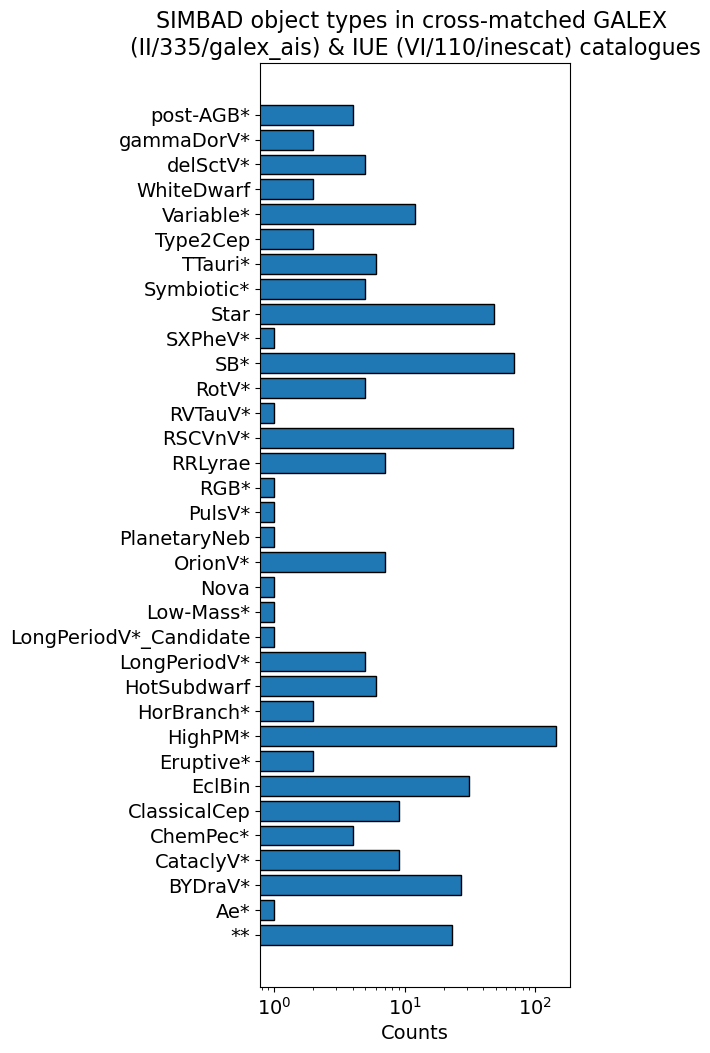

In [360]:
cats = np.unique(results['OTYPE'])
counts = np.zeros(len(cats))

for i in range(len(cats)):
    counts[i] = np.sum( results['OTYPE'] == cats[i] )

plt.figure(figsize=(4,12))
plt.barh(cats, counts, edgecolor='k')
plt.yticks(fontsize=14, c='k');
plt.xticks(fontsize=14, c='k');
plt.xlabel('Counts', fontsize=14, c='k');
plt.title('SIMBAD object types in cross-matched GALEX \n(II/335/galex_ais) & IUE (VI/110/inescat) catalogues', 
          fontsize=16, c='k')
plt.xscale('log')


In [403]:
## Limit dataset to "normal" stars

print( 'Unique object types: \n', np.unique(results['OTYPE'].compressed()) )

drop_types = ['**', 'Ae*', 'BYDraV*', 'CataclyV*', 'ChemPec*', 'ClassicalCep', 'EclBin',
              'Eruptive*', 'Low-Mass*', 'Nova', 'OrionV*', 'PlanetaryNeb',
              'PulsV*', 'RRLyrae', 'RSCVnV*', 'RVTauV*', 'RotV*', 'SB*', 'SXPheV*',
              'Symbiotic*', 'TTauri*', 'Type2Cep', 'Variable*', 'WhiteDwarf',
              'delSctV*', 'gammaDorV*']


dropbool = [True]*len(results)

for objtype in drop_types:

    print(objtype)
    dropbool = dropbool * (results['OTYPE']!=objtype).data 

filtresults = results[dropbool]
print(len(results), len(filtresults))
print(np.unique(filtresults['OTYPE']))

Unique object types: 
 ['**' 'Ae*' 'BYDraV*' 'CataclyV*' 'ChemPec*' 'ClassicalCep' 'EclBin'
 'Eruptive*' 'HighPM*' 'HorBranch*' 'HotSubdwarf' 'LongPeriodV*'
 'LongPeriodV*_Candidate' 'Low-Mass*' 'Nova' 'OrionV*' 'PlanetaryNeb'
 'PulsV*' 'RGB*' 'RRLyrae' 'RSCVnV*' 'RVTauV*' 'RotV*' 'SB*' 'SXPheV*'
 'Star' 'Symbiotic*' 'TTauri*' 'Type2Cep' 'Variable*' 'WhiteDwarf'
 'delSctV*' 'gammaDorV*' 'post-AGB*']
**
Ae*
BYDraV*
CataclyV*
ChemPec*
ClassicalCep
EclBin
Eruptive*
Low-Mass*
Nova
OrionV*
PlanetaryNeb
PulsV*
RRLyrae
RSCVnV*
RVTauV*
RotV*
SB*
SXPheV*
Symbiotic*
TTauri*
Type2Cep
Variable*
WhiteDwarf
delSctV*
gammaDorV*
512 211
        OTYPE         
----------------------
               HighPM*
            HorBranch*
           HotSubdwarf
          LongPeriodV*
LongPeriodV*_Candidate
                  RGB*
                  Star
             post-AGB*


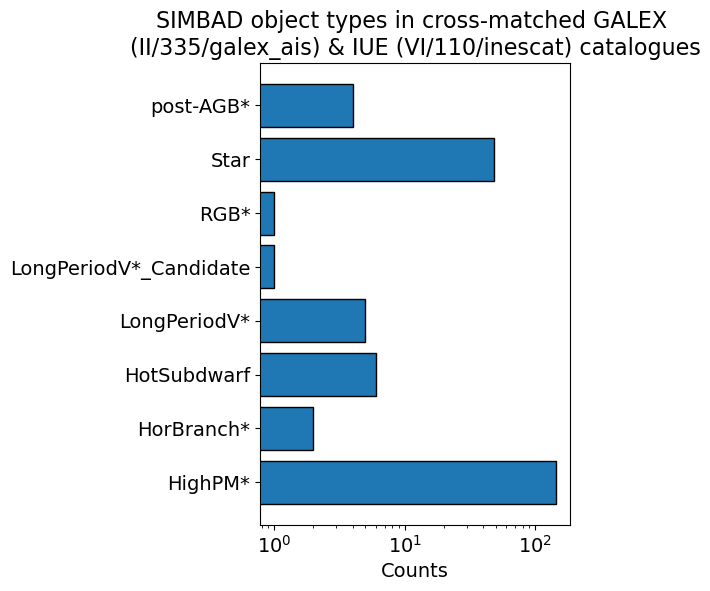

In [406]:
cats = np.unique(filtresults['OTYPE'])
counts = np.zeros(len(cats))

for i in range(len(cats)):
    counts[i] = np.sum( filtresults['OTYPE'] == cats[i] )

plt.figure(figsize=(4,6))
plt.barh(cats, counts, edgecolor='k')
plt.yticks(fontsize=14, c='k');
plt.xticks(fontsize=14, c='k');
plt.xlabel('Counts', fontsize=14, c='k');
plt.title('SIMBAD object types in cross-matched GALEX \n(II/335/galex_ais) & IUE (VI/110/inescat) catalogues', 
          fontsize=16, c='k')
plt.xscale('log')


In [130]:
######## BATCHED OBJECT QUERIES

# warnings.filterwarnings('ignore')

# ## Set fields to query from Simbad
# fields = ['typed_id', 'fe_h', 'flux(B)','flux(V)','flux(R)','flux(I)','flux(J)',
#           'flux(K)', 'flux_error(B)','flux_error(V)','flux_error(R)',
#           'flux_error(I)','flux_error(J)','flux_error(K)', 'rot', 
#           'sptype', 'otype', 'td1', 'ubv', 'parallax', 'distance']

# customSimbad = Simbad()

# for f in fields: 
#     customSimbad.add_votable_fields(f)
    

# ## Query Simbad in batches to avoid timeout
# l = np.min([800, len(match)]) # query in batches of 800 or the length of the table, whichever is smaller
# results = customSimbad.query_objects(match.loc[:l,'Object'])

# ## If match dataframe is larger than one batch of length l, then batch match dataframe into queries of size l
# if len(match) > l:
    
#     i = l
    
#     while i <= len(match):
        
#         ## Track progress
#         print('while: indexing', i, 'through', i+l)
        
#         ## Query Simbad
#         r = customSimbad.query_objects(match.loc[i:i+l,'Object'])

#         ## Add current batch to running query results
#         results = vstack([results, r])
        
#         ## Increment indices
#         i = i + l


while: indexing 800 through 1600
while: indexing 1600 through 2400
while: indexing 2400 through 3200
while: indexing 3200 through 4000
while: indexing 4000 through 4800
while: indexing 4800 through 5600
while: indexing 5600 through 6400
while: indexing 6400 through 7200
while: indexing 7200 through 8000
while: indexing 8000 through 8800
while: indexing 8800 through 9600
while: indexing 9600 through 10400
while: indexing 10400 through 11200
while: indexing 11200 through 12000
while: indexing 12000 through 12800
